### Dataset
Download the MNIST dataset into local memory; this is used to implement the custom Dataset and DataLoader classes.

In [1]:
!rm -rf mnist_data
!mkdir mnist_data
%cd mnist_data

!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

!gunzip *.gz
%cd ..

/Users/akshatgupta/Desktop/IIITD/SEM_6/DL/DL-Assignments/Assignment1/mnist_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  4457k      0  0:00:02  0:00:02 --:--:-- 4458k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  85154      0 --:--:-- --:--:-- --:--:-- 84944
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  1104k      0  0:00:01  0:00:01 --:--:-- 1105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  13366      0 --:--

### Transform 
This is the Transform function used for the custom DataLoader class.

In [2]:
import torch

def tensor_transform(data):
    data = torch.from_numpy(data).to(torch.float32)
    data = torch.div(data,255.0)
    return data

### CustomDataSet Class
This is the implementation of the custom Dataset class that returns a dataset object.

In [3]:
import os, struct
import numpy as np


class CustomDataset:
    def __init__(self,root,train=True):
        """
        Args:
            root (str): path to the directory of the dataset
            train (bool, default=True): if True return training data, else return testing data
        """
        self.root = root
        self.train = train

        self.data_name = ('train-images-idx3-ubyte' if train else 't10k-images-idx3-ubyte')
        self.labels_name = ('train-labels-idx1-ubyte' if train else 't10k-labels-idx1-ubyte')
        self.data, self.labels = self.load_data()


    def load_data(self):
        data_path = os.path.join(self.root, self.data_name)
        labels_path = os.path.join(self.root, self.labels_name)

        with open(data_path, 'rb') as f:
            _, _, rows, cols = struct.unpack('>IIII', f.read(16))
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(-1, 1, rows, cols)
        with open(labels_path, 'rb') as f:
            _, _ = struct.unpack('>II', f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)

        return data, labels


    def __len__(self):
        return len(self.data)


    def __getitem__(self,index):
        img, target = list(self.data[index]), int(self.labels[index])
        return img, target

### CustomDataLoader Class
This is the implementation of the custom DataLoader class that loads the MNIST dataset batch-wise as a dictionary with "data" indicating the image data, and "label" indicating the label of each corresponding sample.

In [4]:
class CustomDataLoader:
    def __init__(self,dataset,batch_size=64,shuffle=False,transform=None):
        """
        Args:
            dataset (obj): Dataset object that will be loaded into the stream; must implement __getitem__ and __len__ functions
            batch_size (int, default=64): batch size
            shuffle (bool, default=False): if True shuffles the data before loading into stream
            transform (callable, default=None): transform function to apply to data
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.num_samples = len(dataset)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size

    def __iter__(self):
        if self.shuffle:
            indices = torch.randperm(self.num_samples)
        else:
            indices = torch.arange(self.num_samples)

        for i in range(0, self.num_samples, self.batch_size):
            batch_indices = indices[i:min(self.num_samples,i+self.batch_size)]
            batch = [self.dataset[index] for index in batch_indices]
            batch = tuple(zip(*batch))
            data, label = batch

            if self.transform is not None:
                data = self.transform(np.array(data))

            yield {'data':data,'label':torch.from_numpy(np.array(label))}

    def __len__(self):
        return self.num_batches

In [5]:
trdata = CustomDataset(
    root="./mnist_data/",
    train=True
)
traindata,valdata = torch.utils.data.random_split(trdata,[50000,10000])
testdata = CustomDataset(
    root="./mnist_data/",
    train=False
)

### Dataset using ```torch.utils.data.Dataset```
This class loads the MNIST dataset using the implementation that PyTorch provides.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {'data': image, 'label': label}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x:x/255.0)])
mnist_data = MNISTDataset(root="./mnist_data/",transform=transform)

100%|██████████| 9912422/9912422 [00:02<00:00, 3709827.91it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9301673.49it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1010326.41it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7361100.76it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### Performance Comparison of DataLoaders
The following blocks of code compare the performance of the CustomDataLoader and the torch.utils.data.DataLoader objects against different batch sizes.

The graph indicates that the CustomDataLoader loads data faster at smaller batch sizes, but is out-performed at larger batch sizes. The mean performance time indicates the CustomDataLoader loads data faster than the torch.utils.data.DataLoader object and is thus used for all further tasks.

In [8]:
import time

def measure_dataloader_time(dataloader):
    start_time = time.time()
    for batch in dataloader:
        data,labels = batch
        print(batch)
        end_time = time.time()
        return end_time - start_time

In [9]:
batch_sizes = [128,256,512,1024]

dataloader_1_times = []
dataloader_2_times = []

for batch_size in batch_sizes:
    dataloader_1 = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)
    time_taken = measure_dataloader_time(dataloader_1)
    dataloader_1_times.append(time_taken)

    dataloader_2 = CustomDataLoader(dataset=traindata,batch_size=batch_size,shuffle=True,transform=tensor_transform)
    time_taken = measure_dataloader_time(dataloader_2)
    dataloader_2_times.append(time_taken)

{'data': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

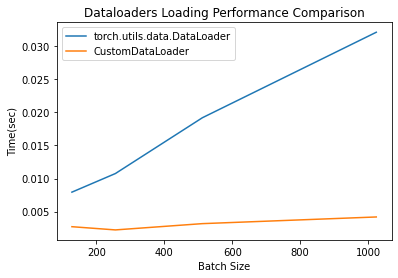

In [10]:
import matplotlib.pyplot as plt

plt.plot(batch_sizes, dataloader_1_times, label='torch.utils.data.DataLoader')
plt.plot(batch_sizes, dataloader_2_times, label='CustomDataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Time(sec)')
plt.title('Dataloaders Loading Performance Comparison')
plt.legend()
plt.show()

In [11]:
dataloader_1_times

[0.007940053939819336,
 0.010754108428955078,
 0.019191980361938477,
 0.03212475776672363]

In [12]:
dataloader_2_times

[0.002713918685913086,
 0.0022268295288085938,
 0.0031762123107910156,
 0.004185199737548828]

In [13]:
np.mean(dataloader_1_times)

0.01750272512435913

In [14]:
np.mean(dataloader_2_times)

0.003075540065765381

### Feed-Forward NN (FFN)
This is the implementation of the Feed-Forward Neural Network using the PyTorch library functions and classes.

In [15]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self,input_size,hidden_sizes,num_classes,activation=torch.nn.ReLU(inplace=True),softmax=torch.nn.LogSoftmax(dim=1)):
        super(FeedForwardNN, self).__init__()
        self.activation = activation

        self.fc1 = torch.nn.Linear(input_size, hidden_sizes[0])
        self.act1 = self.activation
        self.bn1 = torch.nn.BatchNorm1d(num_features=hidden_sizes[0])

        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.act2 = self.activation
        self.bn2 = torch.nn.BatchNorm1d(num_features=hidden_sizes[1])

        self.fc3 = torch.nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.act3 = self.activation
        self.bn3 = torch.nn.BatchNorm1d(num_features=hidden_sizes[2])

        self.fc4 = torch.nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.act4 = self.activation
        self.bn4 = torch.nn.BatchNorm1d(num_features=hidden_sizes[3])

        self.fc_out = torch.nn.Linear(hidden_sizes[3], num_classes)
        self.softmax = softmax

    
    def forward(self,x):
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.act2(self.bn2(self.fc2(x)))
        x = self.act3(self.bn3(self.fc3(x)))
        x = self.act4(self.bn4(self.fc4(x)))
        x = self.softmax(self.fc_out(x))

        return x

In [16]:
model1 = FeedForwardNN(
    input_size=28*28,
    hidden_sizes=[512,128,64,32],
    num_classes=10
)

loss1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(params=model1.parameters(),lr=0.0003)

In [17]:
batch_size = 32

trainloader = CustomDataLoader(
    traindata,
    batch_size=batch_size,
    shuffle=True,
    transform=tensor_transform
)
valloader = CustomDataLoader(
    valdata,
    batch_size=batch_size,
    shuffle=True,
    transform=tensor_transform
)
testloader = CustomDataLoader(
    testdata,
    batch_size=batch_size,
    shuffle=True,
    transform=tensor_transform
)

### Training the Model
An instance of the FFN is trained with learning rate = 0.0003 for 60 epochs with Cross-Entropy Loss and Stochastic Gradient Descent as the updation policy.

In [18]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]
n_epochs = 60

# mps_device = torch.device('mps')
# model1.to(mps_device)

for epoch in range(n_epochs):
    model1.train(mode=True)
    correct = 0
    n_samples = 0
    total_loss = 0

    for idx,batch in enumerate(trainloader):
        optimizer1.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model1(inputs)
        l = loss1(outputs,labels)
        l.backward()
        optimizer1.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples

    train_loss.append(avg_train_l)
    train_acc.append(train_a)


    model1.train(mode=False)
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model1(inputs)
            l = loss1(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,dim=1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    model1.train(mode=False)
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model1(inputs)
            l = loss1(valoutputs,vallabels)

            _,pred = torch.max(valoutputs,dim=1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)


    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}\nVal Loss: {avg_val_l}, Val Accuracy: {val_a}\n")
    

Epoch 1/60:
Train Loss: 1.8525094403262636, Train Accuracy: 0.48904
Val Loss: 1.547022552916798, Val Accuracy: 0.6874

Epoch 2/60:
Train Loss: 1.4277216428682276, Train Accuracy: 0.72648
Val Loss: 1.2626552139989102, Val Accuracy: 0.8109

Epoch 3/60:
Train Loss: 1.184133853312875, Train Accuracy: 0.80774
Val Loss: 1.062567275743515, Val Accuracy: 0.8632

Epoch 4/60:
Train Loss: 0.9970788288711357, Train Accuracy: 0.84842
Val Loss: 0.8469518546860058, Val Accuracy: 0.8885

Epoch 5/60:
Train Loss: 0.8500476846768165, Train Accuracy: 0.86898
Val Loss: 0.7282618732688526, Val Accuracy: 0.898

Epoch 6/60:
Train Loss: 0.7357360142702029, Train Accuracy: 0.88442
Val Loss: 0.6220357268572615, Val Accuracy: 0.9122

Epoch 7/60:
Train Loss: 0.6423621637960009, Train Accuracy: 0.8963
Val Loss: 0.5316942994015667, Val Accuracy: 0.9189

Epoch 8/60:
Train Loss: 0.5689491349119296, Train Accuracy: 0.90546
Val Loss: 0.4723013384273639, Val Accuracy: 0.9283

Epoch 9/60:
Train Loss: 0.5135825725793076, T

### Performance of PyTorch FFN
The following graphs show the performance of the FFN on the train, val, and test sets for each epoch.

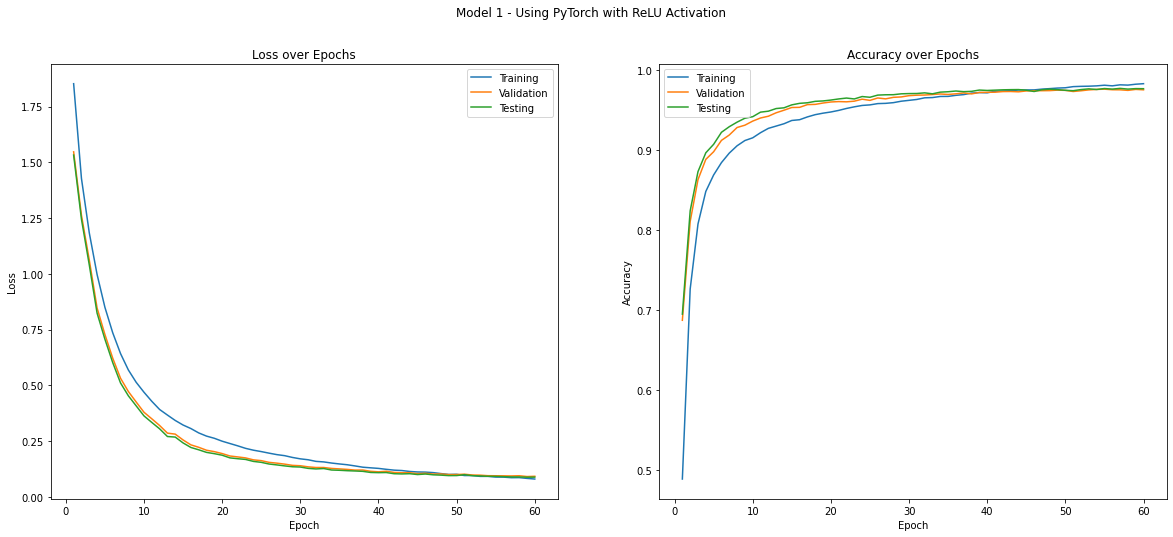

In [19]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 1 - Using PyTorch with ReLU Activation")
plt.show()

### Scratch Implementation
The following classes and functions implement the FFN, ReLU activation, and Stochastic Gradient Descent from scratch without using the PyTorch modules.

This is the implementation of the activations - ReLU and LogSoftmax - functions used for this network.

In [20]:
class CustomReLU:
    def __init__(self):
        self.A = None
        self.Z = None

    def forward(self,Z):
        self.Z = Z
        self.A = torch.max(Z,torch.zeros_like(Z))
        return self.A
    __call__ = forward

    def backward(self,dA):
        dZ = dA * (self.Z>0).float()
        return dZ
    

class CustomSigmoid:
    def __init__(self):
        self.A = None
        self.Z = None

    def forward(self,Z):
        self.Z = Z
        self.A = 1.0/(1.0 + torch.exp(-1*Z))
        return self.A
    __call__=forward

    def backward(self,dA):
        dZ = dA * self.A*(1-self.A)
        return dZ


## Used log softmax for numerical stability
class CustomLogSoftmax:
    def forward(self,Z):
        Z_max,_ = torch.max(Z,dim=1,keepdim=True)
        Z = Z-Z_max
        self.Z = Z

        denom = torch.sum(torch.exp_(Z),dim=1,keepdim=True)
        out = torch.div(Z,denom)
        return out
    __call__ = forward

    def backward(self,dZ):
        diag_elements = self.forward(self.Z)
        grad_Z = dZ.add_(-diag_elements)

        return grad_Z

This is the implementation of the Linear layers and the Batch Normalization layers used for the network.

In [21]:
class CustomLinear:
    def __init__(self,n_in,n_out):
        self.input = None
        ## Uses the Xavier initialization method for weights
        self.W = torch.randn(n_in,n_out)*torch.sqrt(torch.tensor(2.0/(n_in+n_out))).to(torch.float32)
        self.W.to(torch.float32)

        self.b = torch.zeros(n_out)
        ## Initialize all gradients to 0 initially
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)


    def forward(self,data):
        self.input = data
        self.output = torch.mm(self.input,self.W).add_(self.b)
        return self.output
    __call__ = forward


    def backward(self, dZ):
        self.dW = torch.mm(input=self.input.t(),mat2=dZ)/dZ.shape[0]
        self.db = torch.mean(dZ)
        self.dA = torch.mm(dZ,self.W.t())
        return self.dA
    

class CustomBatchNormalization:
    def __init__(self,n_out):
        self.gamma = torch.ones(n_out)
        self.beta = torch.zeros(n_out)

        self.dgamma = torch.zeros(self.gamma.shape)
        self.dbeta = torch.zeros(self.beta.shape)

        self.mean = torch.tensor(0.0)
        self.var = torch.tensor(0.0)

        self.mean_avg = self.mean
        self.var_avg = self.var

        self.epsilon = 1e-7
        self.is_training = True

    
    def forward(self, Z):
        self.Z = Z

        mean = torch.mean(Z,dim=0)
        self.mean = mean

        var = torch.var(Z,dim=0)
        self.var = var

        if self.is_training:
            self.Z_hat = (self.Z.add_(-1*mean))/torch.sqrt(var.add_(self.epsilon))
        else:
            self.Z_hat = self.Z.add_(-self.mean_avg)/torch.sqrt(self.var_avg.add_(self.epsilon))

        output = (self.gamma*self.Z_hat).add_(self.beta)
        return output

    __call__ = forward


    def backward(self,dA):
        self.dgamma = torch.sum(dA*self.Z_hat,dim=0)
        self.dbeta = torch.sum(dA,dim=0)
        dZ_hat = dA * self.gamma

        xmu = self.Z.add_(-1*self.mean)
        sqrtvar = torch.sqrt(self.var.add_(self.epsilon))
        divar = torch.sum(dZ_hat*xmu,dim=0)

        dsqrtvar = (-1./(sqrtvar**2))*divar
        dvar = 0.5*1./sqrtvar * dsqrtvar
        dsq = (1./(dA.size(0))) * torch.ones_like(dA) * dvar

        dxmu1 = dZ_hat*(1.0/sqrtvar)
        dxmu2 = 2*xmu*dsq
        
        dx1 = (dxmu1 + dxmu2)
        dmu = -1*torch.sum(dx1,dim=0)

        dx2 = (1./(dA.size(0)))*torch.ones_like(dA)*dmu
        dZ = dx1+dx2

        return dZ


This is the implementation of the Feed Forward Network using the Linear and Batch Normalization layers.

In [22]:
class CustomFFN:
    def __init__(self,input_size,hidden_sizes,output_size,activation):
        self.layers = []

        for i in range(len(hidden_sizes)+1):
            in_size = input_size if i==0 else hidden_sizes[i-1]
            out_size = output_size if i==len(hidden_sizes) else hidden_sizes[i]

            self.layers.append(CustomLinear(in_size,out_size))
            if i!=(len(hidden_sizes)-1):
                self.layers.append(CustomBatchNormalization(out_size))

            act_layer = ((CustomSigmoid() if activation=='sigmoid' else CustomReLU()) if (i<(len(hidden_sizes))) else CustomLogSoftmax())
            self.layers.append(act_layer)


    def forward(self,data,train=True):
        X = data
        ## Iterate over hidden layers and apply to data
        for layer in self.layers:
            if not isinstance(layer,CustomLinear):
                layer.is_training = train
            X = layer(X)
        return X
    __call__ = forward

This is the implementation of the Stochastic Gradient Descent optimizer.

In [23]:
class CustomSGD:
    def __init__(self,model,learning_rate):
        self.lr = learning_rate
        self.model = model

    def step(self):
        for layer in reversed(self.model.layers):
            if isinstance(layer,CustomLinear):
                layer.W.add_(-self.lr*layer.dW)
                layer.b.add_(-self.lr*layer.db)
            elif isinstance(layer,CustomBatchNormalization):
                layer.gamma.add_(-self.lr*layer.dgamma)
                layer.beta.add_(-self.lr*layer.dbeta)

    def zero_grad(self):
        for layer in self.model.layers:
            if isinstance(layer,CustomLinear):
                layer.dW.zero_()
                layer.db.zero_()
            elif isinstance(layer,CustomBatchNormalization):
                layer.dgamma.zero_()
                layer.dbeta.zero_()

This is the implementation of the Cross Entropy Loss function.

In [24]:
class CustomCrossEntropyLoss:
    def __init__(self,model,n_classes):
        self.model = model
        self.n_classes = n_classes


    def _one_hot(self,y):
        res = torch.zeros([y.shape[0],self.n_classes])
        for i in range(y.shape[0]):
            res[i, y[i]] = 1
        return res

    
    def loss(self,y_hat,y):
        self.y = self._one_hot(y)
        eps = torch.zeros_like(y_hat)+1e-10
        preds = torch.max(y_hat,eps)
        self.y_hat = preds

        l = torch.sum((self.y*torch.log(self.y_hat)),dim=1,keepdim=True)
        cost = -1*torch.mean(l)
        cost = torch.squeeze(cost)
        return cost
    __call__=loss
    

    def backward(self):
        dZ = self.y_hat - self.y
        d_out = dZ
        for idx,layer in enumerate(reversed(self.model.layers)):
            if(idx==0): continue
            d_out = layer.backward(d_out)

In [25]:
model2 = CustomFFN(
    input_size=28*28,
    hidden_sizes=[512,128,64,32],
    output_size=10,
    activation='relu'
)
# model2.to(mps_device)

loss2 = CustomCrossEntropyLoss(model=model2,n_classes=10)
optimizer2 = CustomSGD(model=model2,learning_rate=0.0003)

### Training Loop
The custom implemented FFN is trained on the same data with the same parameters as the PyTorch implementation.

In [26]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]
n_epochs = 60

for epoch in range(n_epochs):
    correct = 0
    n_samples = 0
    total_loss = 0
    
    for idx,batch in enumerate(trainloader):
        optimizer2.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model2(inputs,True)
        l = loss2(outputs,labels)
        loss2.backward()
        optimizer2.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples
    
    train_loss.append(avg_train_l)
    train_acc.append(train_a)

    
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model2(inputs,False)
            l = loss2(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model2(inputs,False)
            l = loss2(valoutputs,vallabels)
            
            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)

    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}\nVal Loss: {avg_val_l}, Val Accuracy: {val_a}\n")

Epoch 1/60:
Train Loss: 1.6454942551318148, Train Accuracy: 0.47742
Val Loss: 9.045738875294646, Val Accuracy: 0.3454

Epoch 2/60:
Train Loss: 0.9715614398930672, Train Accuracy: 0.72162
Val Loss: 7.511908197555298, Val Accuracy: 0.4565

Epoch 3/60:
Train Loss: 0.7132500507132945, Train Accuracy: 0.79528
Val Loss: 6.554643368949525, Val Accuracy: 0.5258

Epoch 4/60:
Train Loss: 0.585791438226889, Train Accuracy: 0.83046
Val Loss: 6.016699125972419, Val Accuracy: 0.5644

Epoch 5/60:
Train Loss: 0.5130426832215571, Train Accuracy: 0.8498
Val Loss: 5.673242447856135, Val Accuracy: 0.5893

Epoch 6/60:
Train Loss: 0.4664427714323433, Train Accuracy: 0.86304
Val Loss: 5.389097569468684, Val Accuracy: 0.61

Epoch 7/60:
Train Loss: 0.42595450299352844, Train Accuracy: 0.8727
Val Loss: 5.204265431283762, Val Accuracy: 0.6236

Epoch 8/60:
Train Loss: 0.40309491687795707, Train Accuracy: 0.8793
Val Loss: 5.111849371998455, Val Accuracy: 0.6299

Epoch 9/60:
Train Loss: 0.3739107191438715, Train Ac

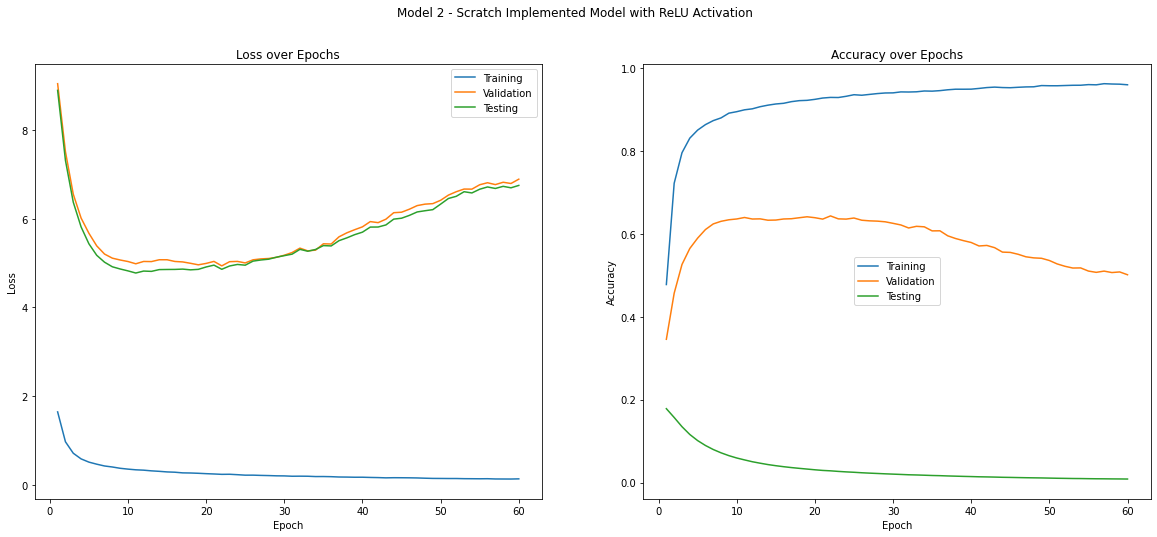

In [27]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 2 - Scratch Implemented Model with ReLU Activation")
plt.show()

### Sigmoid Activation
The following is the performance report of each of the 2 architectures with sigmoid activations instead of ReLU activations.

In [28]:
model3 = FeedForwardNN(
    input_size=28*28,
    hidden_sizes=[512,128,64,32],
    num_classes=10,
    activation=torch.nn.Sigmoid()
)
# model3.to(mps_device)

loss3 = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(params=model3.parameters(),lr=0.0003)

In [29]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]
n_epochs = 60

for epoch in range(n_epochs):
    model3.train(mode=True)
    correct = 0
    n_samples = 0
    total_loss = 0

    for idx,batch in enumerate(trainloader):
        optimizer3.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model3(inputs)
        l = loss3(outputs,labels)
        l.backward()
        optimizer3.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples

    train_loss.append(avg_train_l)
    train_acc.append(train_a)


    model3.train(mode=False)
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model3(inputs)
            l = loss3(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    model3.train(mode=False)
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model3(inputs)
            l = loss3(valoutputs,vallabels)

            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()


    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)


    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}\nVal Loss: {avg_val_l}, Val Accuracy: {val_a}\n")


Epoch 1/60:
Train Loss: 2.1860605390576775, Train Accuracy: 0.27036
Val Loss: 2.079057621117979, Val Accuracy: 0.4429

Epoch 2/60:
Train Loss: 2.0296914932900183, Train Accuracy: 0.51736
Val Loss: 1.9844695542947934, Val Accuracy: 0.6088

Epoch 3/60:
Train Loss: 1.9511480871409235, Train Accuracy: 0.657
Val Loss: 1.9143488403326405, Val Accuracy: 0.7203

Epoch 4/60:
Train Loss: 1.894007772798349, Train Accuracy: 0.7262
Val Loss: 1.8700597141497433, Val Accuracy: 0.749

Epoch 5/60:
Train Loss: 1.8457970642082522, Train Accuracy: 0.75846
Val Loss: 1.8230888557891114, Val Accuracy: 0.7829

Epoch 6/60:
Train Loss: 1.8026156012095174, Train Accuracy: 0.77976
Val Loss: 1.7797430193843171, Val Accuracy: 0.794

Epoch 7/60:
Train Loss: 1.7624332508214071, Train Accuracy: 0.7918
Val Loss: 1.7433035343218917, Val Accuracy: 0.8087

Epoch 8/60:
Train Loss: 1.7231970597594806, Train Accuracy: 0.80276
Val Loss: 1.7057861817149689, Val Accuracy: 0.8193

Epoch 9/60:
Train Loss: 1.6862794036523547, Trai

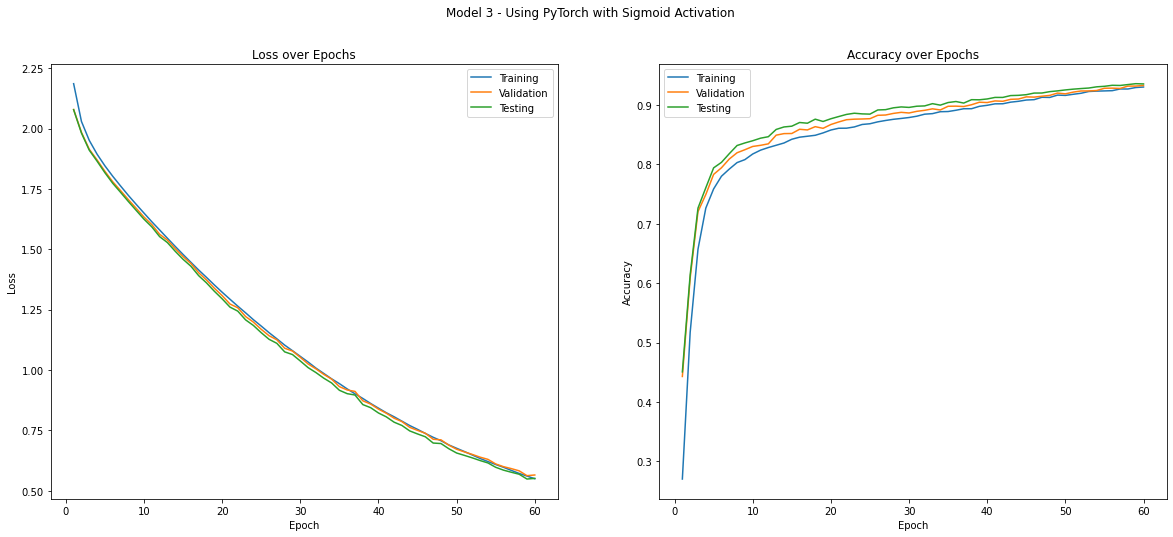

In [30]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 3 - Using PyTorch with Sigmoid Activation")
plt.show()

In [31]:
model4 = CustomFFN(
    input_size=28*28,
    hidden_sizes=[512,128,64,32],
    output_size=10,
    activation='sigmoid'
)
# model2.to(mps_device)

loss4 = CustomCrossEntropyLoss(model=model4,n_classes=10)
optimizer4 = CustomSGD(model=model4,learning_rate=0.0003)

In [32]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]
n_epochs = 60

for epoch in range(n_epochs):
    correct = 0
    n_samples = 0
    total_loss = 0
    
    for idx,batch in enumerate(trainloader):
        optimizer4.zero_grad()
        data,labels = batch['data'],batch['label']
        # data = data.to(mps_device)
        # labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model4(inputs,True)
        l = loss4(outputs,labels)
        loss4.backward()
        optimizer4.step()

        _,pred = torch.max(outputs,dim=1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples
    
    train_loss.append(avg_train_l)
    train_acc.append(train_a)

    
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch['data'],batch['label']
            # testsamples = testsamples.to(mps_device)
            # testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model4(inputs,False)
            l = loss4(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch['data'],batch['label']
            # valsamples = valsamples.to(mps_device)
            # vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model4(inputs,False)
            l = loss4(valoutputs,vallabels)
            
            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)

    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}\nVal Loss: {avg_val_l}, Val Accuracy: {val_a}\n")

Epoch 1/60:
Train Loss: 1.464479616492205, Train Accuracy: 0.54256
Val Loss: 11.39363784454882, Val Accuracy: 0.1459

Epoch 2/60:
Train Loss: 1.5018075242762525, Train Accuracy: 0.5276
Val Loss: 12.303091116225758, Val Accuracy: 0.1004

Epoch 3/60:
Train Loss: 1.401223475171905, Train Accuracy: 0.60108
Val Loss: 11.613861215000336, Val Accuracy: 0.1312

Epoch 4/60:
Train Loss: 1.1167604857656488, Train Accuracy: 0.686
Val Loss: 10.368437785310105, Val Accuracy: 0.2138

Epoch 5/60:
Train Loss: 1.1165019867134949, Train Accuracy: 0.67352
Val Loss: 11.085277872725417, Val Accuracy: 0.1604

Epoch 6/60:
Train Loss: 1.1252325466826263, Train Accuracy: 0.67106
Val Loss: 10.069632198102177, Val Accuracy: 0.2038

Epoch 7/60:
Train Loss: 1.135089852607029, Train Accuracy: 0.68376
Val Loss: 10.29863452911377, Val Accuracy: 0.2229

Epoch 8/60:
Train Loss: 1.8217105751455556, Train Accuracy: 0.4462
Val Loss: 12.037499900062244, Val Accuracy: 0.0965

Epoch 9/60:
Train Loss: 1.4917365827014335, Train

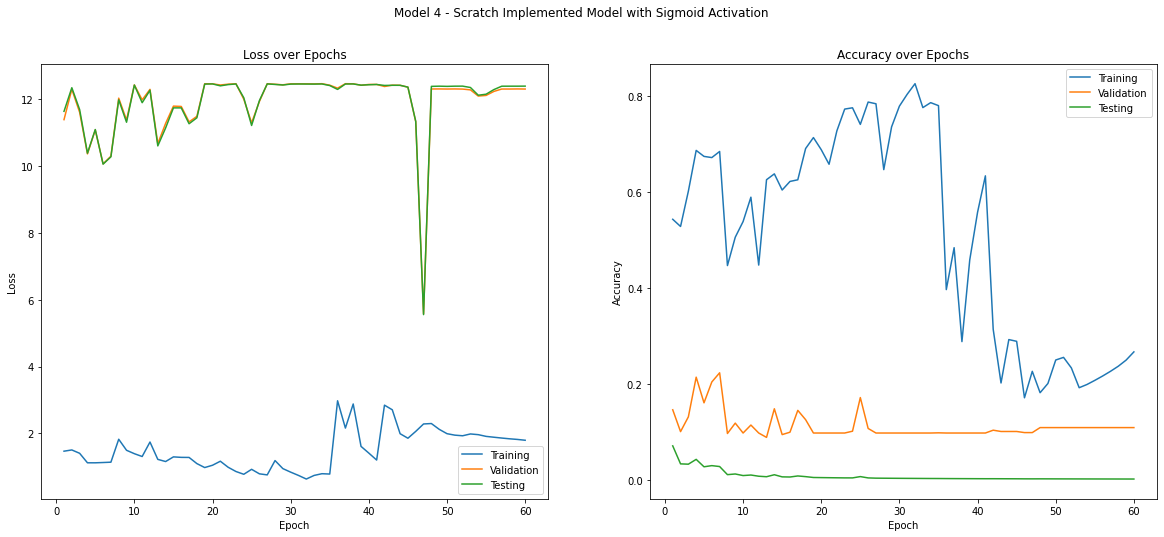

In [33]:
plt.figure(figsize=(20, 8))

## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.suptitle("Model 4 - Scratch Implemented Model with Sigmoid Activation")
plt.show()